To do:
1. Structure the class encoder and ConvCNP better: Allow for variable CNN to be defined
(Is it necessary that the height and width of output feature map is the same the input height and width? Otherwise,
it gets a mess)
2. Plot_inference_2d should also plot variance
3. Define training function for ConvCNP and train on GP data
4. Show in an example with plot that equivariance is not fulfilled (maybe one before training, one after traing)


In [17]:
#LIBRARIES:
#Tensors:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import Kernel_and_GP_tools as GP

#Plotting in 2d/3d:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline

In [18]:
#HYPERPARAMETERS:
#Set default as double:
torch.set_default_dtype(torch.double)

In [19]:
#SOME TOOLS:
#A tool to make a 2d_grid:
def make_2d_grid(min_x,max_x,n_x_axis,min_y=None,max_y=None,n_y_axis=None,flatten=True):
    '''
    Input:
        min_x,max_x,min_y,max_y: float - range of x-axis/y-axis
        n_x_axis,n_y_axis: int - number of points per axis
        flatten: Boolean - determines shape of output
    Output:
        torch.tensor - if flatten is True: shape (n_x_axis*n_y_axis,2)
                       if flatten is not True: shape (n_x_axis,n_y_axis,2)
    '''
    if min_y is None:
        min_y=min_x
    if max_y is None:
        max_y=max_x
    if n_y_axis is None:
        n_y_axis=n_x_axis
        
    x_grid_vec=torch.linspace(min_x,max_x,n_x_axis)
    y_grid_vec=torch.linspace(min_y,max_y,n_y_axis)
    X1,X2=torch.meshgrid(x_grid_vec,y_grid_vec)
    X=torch.stack((X1,X2),2)
    if flatten:
        X=X.view(n_x_axis*n_y_axis,2)
    return(X)

#Tool to split a function in a context and target set (choice is random but size of context set is given):
def Rand_Target_Context_Splitter(X,Y,n_context_points):
    '''
    Inputs: X: torch.tensor - shape (n,d) - n...number of observations, d...dimension of state space
            Y: torch.tensor - shape (n,D) - N...number of observations, D...dimension of label space
            n_context_points: int - size of context set
    Outputs:
        X_Context: torch.tensor - shape (n_context_points,d)
        Y_Context: torch.tensor - shape (n_context_points,D)
        X_Target:  torch.tensor - shape (n-n_context_points,d)
        Y_Target:  torch.tensor - shape (n-n_context_points,D)
    '''
    n=X.size(0)
    ind_shuffle=torch.randperm(n)
    X_Context=X[ind_shuffle[:n_context_points],]
    Y_Context=Y[ind_shuffle[:n_context_points],]
    X_Target=X[ind_shuffle[n_context_points:,]]
    Y_Target=Y[ind_shuffle[n_context_points:,]]
    return(X_Context,Y_Context,X_Target,Y_Target)
           
#Tool to plot context set, ground truth for target and predictions for target in one plot:
#!!!This function is still lacking a variance plot (so the second plot will be empty)
def Plot_inference_2d(X_Context,Y_Context,X_Target=None,Y_Target=None,Predict=None):
    '''
    Inputs: X_Context,Y_Context: torch.tensor - shape (n_context_points,2) - given context set
            X_Target,Y_Target: torch.tensor - shape (n_target_points,2) - target locations and outputs vectors 
            Predict: torch.tensor - shape (n_target_points,2) - target predictions (i.e. predicting Y_Target)
    Outputs: None - plots the above tensors
    '''
    #Function hyperparameters for plotting in notebook:
    size_scale=2
    
    #Create plots:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(size_scale*10,size_scale*5))
    #Plot context set in blue:
    ax[0].scatter(X_Context[:,0],X_Context[:,1],color='blue')
    ax[0].quiver(X_Context[:,0],X_Context[:,1],Y_Context[:,0],Y_Context[:,1],color='blue',pivot='mid')
    
    #Plot ground truth in red if given:
    if Y_Target is not None and X_Target is not None:       
        ax[0].quiver(X_Target[:,0],X_Target[:,1],Y_Target[:,0],Y_Target[:,1],color='red',pivot='mid')
    
    #Plot predicted means in green:
    if  Predict is not None and X_Target is not None:
        ax[0].quiver(X_Target[:,0],X_Target[:,1],Predict[:,0],Predict[:,1],color='green',pivot='mid')
               

In [26]:
class ConvCNP_Encoder(nn.Module):
    def __init__(self, dim_X, x_range,y_range=None,kernel_type="rbf",n_x_axis=10,n_y_axis=None):
        super(ConvCNP_Encoder, self).__init__()
        '''
        Inputs:
            dim_X: int - dimension of state space
            x_range,y_range: float lists of size 2 - give range of grid points at x-axis/y-axis
            kernel_type: string - type of kernel to use for embedding
            n_x_axis: int - number of grid points along the x-axis
            n_y_axis: int - number of grid points along the y-axis
        '''
        self.dim_X=dim_X
        self.dim_Y=2
        self.kernel_type=kernel_type
        self.x_range=x_range
        self.n_x_axis=n_x_axis

        #If y_range is None set to the same as x_range:
        if y_range is not None:
            self.y_range=y_range
        else:
            self.y_range=x_range
        #If n_y_axis is None set to the same as n_y_axis:
           
        if n_y_axis is not None:
            self.n_y_axis=n_y_axis
        else:
            self.n_y_axis=n_x_axis
            
        #Create a flattened grid: Periodic grid is y-axis - repetitive grid is x-axis
        #i.e. self.grid[k*n_y_axis+j] corresponds to unflattended Grid[k][j]
        self.grid=make_2d_grid(min_x=self.x_range[0],max_x=self.x_range[1],
                               min_y=self.y_range[0],max_y=self.y_range[1],
                               n_x_axis=self.n_x_axis,n_y_axis=self.n_y_axis,flatten=True)
        
    #This is the function y->(1,y,y^2,y^3,...,y^n) in the ConvCNP paper - for now it just adding a one to every y: y->(1,y):
    def Psi(self,Y):
        '''
        Input: Y - torch.tensor - shape (n,2)
        Output: torch.tensor -shape (n,3) - added a column of ones to Y (at the start, i.e. row 0)
        '''
        return(torch.cat((torch.ones(Y.size(0)).unsqueeze(1),Y),dim=1))
        
    def forward(self,X,Y,normalize=True):
        '''
        Inputs:
            X: torch.tensor - shape (n,self.dim_X)
            Y: torch.tensor - shape (n,self.dim_Y)
            x_range: List of floats - size 2 - x_range[0] gives minimum x-grid, x_range[1] - gives maximum x-grid
            y_range: List of floats - size 2 - y_range[0] gives minimum y-grid, y_range[1] - gives maximum y-grid
                     if None: x_range is taken
            n_grid_points: int - number of grid points per dimension 
        Outputs:
            torch.tensor - shape (D,n_x_axis,n_y_axis) where D is the output dimension of D - for now: D=self.dim_Y+1
        '''
        #Compute for every grid-point x' the value k(x',x_i) for all x_i in the data 
        #i.e. compute the matrix k(Grid,X):
        Gram=GP.Gram_matrix(self.grid,X,kernel_type=self.kernel_type,B=torch.ones((1)))
        #Note Gram[k*n_y_axis+j,l]=k(Grid[k,j],X[l])
        
        #Compute feature expansion:
        Expand_Y=self.Psi(Y)
        #Compute feature map - get shape (n_x_axis*n_y_axis,3)
        Feature_Map=torch.mm(Gram,Expand_Y)
        
        #If wanted, normalize the weights for the channel which is not the density channel:
        if normalize:
            #Normalize the functional representation:
            Feature_Map[:,1:]=Feature_Map[:,1:]/torch.sum(Gram,1).view(-1,1)
        
        #Reshape the Feature Map to the form (n_channels=3,n_y_axis,n_x_axis) (because this is the form required for a CNN):
        return(Feature_Map.view(self.n_x_axis,self.n_y_axis,Expand_Y.size(1)).permute(dims=(2,1,0)))
        

In [27]:
#A class which defines a ConvCNP:
#Still to do:
#1. Define a training function 
#2. Allow for a variable CNN (the CNN used so far is fixed)
class ConvCNP(nn.Module):
    def __init__(self,x_range,y_range=None,kernel_type="rbf",n_x_axis=10,n_y_axis=None):
        '''
        Inputs:
            x_range,y_range,kernel_type,n_x_axis,n_y_axis: see ConvCNP_Encoder            
        '''
        
        super(ConvCNP, self).__init__()
        self.encoder=ConvCNP_Encoder(2,x_range,y_range,kernel_type,n_x_axis,n_y_axis)
        #Decoder: For now: A standard CNN whose parameters are arbitrary for now:
        self.decoder=nn.Sequential(nn.Conv2d(3,5,kernel_size=5,stride=1,padding=2),
              nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
              nn.Conv2d(5,8,kernel_size=7,stride=1,padding=3),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
              nn.Conv2d(8,4,kernel_size=5,stride=1,padding=2))
        
    #Define the forward pass of ConvCNP: 
    #1.Context Set -> Embedding (via Encoder) 
    #2.Embedding ->Feature Map (via CNN), 
    #3.Feature Map -> Predictions on Target Set (via Kernel smoothing)
    def forward(self,X_context,Y_context,X_target=None):
        '''
        Inputs:
            X_context: torch.tensor - shape (n_context,2)
            Y_context: torch.tensor - shape (n_context,2)
            X_target: torch.tensor - shape (n_target,2)
        Outputs:
            Means_target: torch.tensor - shape (n_target,2) - mean of predictions
            Vars_target: torch.tensor -shape (n_target,2) - var of predictions
        '''
        #1.Context Set -> Embedding (via Encoder):
        Embedding=self.encoder(X_context,Y_context)
        #2.Embedding ->Feature Map (via CNN):
        Final_Feature_Map=self.decoder(Embedding.unsqueeze(0)).squeeze()
        #Split into mean and variance and "make variance positive":
        Means_grid=Final_Feature_Map[:2]
        Vars_grid=torch.log(1+torch.exp(Final_Feature_Map[2:]))
        
        #Reshape from (2,n_y_axis,n_x_axis) to (n_x_axis*n_y_axis,2) 
        Means_grid=Means_grid.permute(dims=(2,1,0))
        Means_grid=Means_grid.reshape(self.encoder.n_x_axis*self.encoder.n_y_axis,2)
        Vars_grid=Vars_grid.permute(dims=(2,1,0))
        Vars_grid=Vars_grid.reshape(self.encoder.n_x_axis*self.encoder.n_y_axis,2)
        
        #3.Feature Map -> Predictions on Target Set (via Kernel smoothing)
        #Compute covariance matrix K(X_Target,Grid) - gives the weights for predictions:
        Gram_Target=GP.Gram_matrix(X_Target,self.encoder.grid,kernel_type=self.encoder.kernel_type,B=torch.ones((1)))
        Means_target=torch.mm(Gram_Target,Means_grid)
        Vars_target=torch.mm(Gram_Target,Vars_grid)
        return(Means_target, Vars_target)
    
    def plot_Context_Target(self,X_Context,Y_Context,X_Target,Y_Target=None):
        '''
            Inputs: X_Context, Y_Context, X_Target: torch.tensor - see self.forward
                    Y_Target: torch.tensor - shape (n_context_points,2) - ground truth
            Output: None - plots predictions
        
        '''
        #Get predictions:
        Means,Var=self.forward(X_Context,Y_Context,X_Target)
        #Plot predictions against ground truth:
        Plot_inference_2d(X_Context,Y_Context,X_Target,Y_Target,Predict=Means.detach())

In [28]:
#Create a Test ConvCNP:
Convolut_CNP=ConvCNP(x_range=[-2,2],y_range=[-2,2],n_x_axis=30,n_y_axis=30)

In [29]:
#Create artifical data:
X_Context=torch.randn((10,2))
Y_Context=torch.randn((10,2))
X_Target=torch.randn((50,2))
Y_Target=torch.randn((50,2))

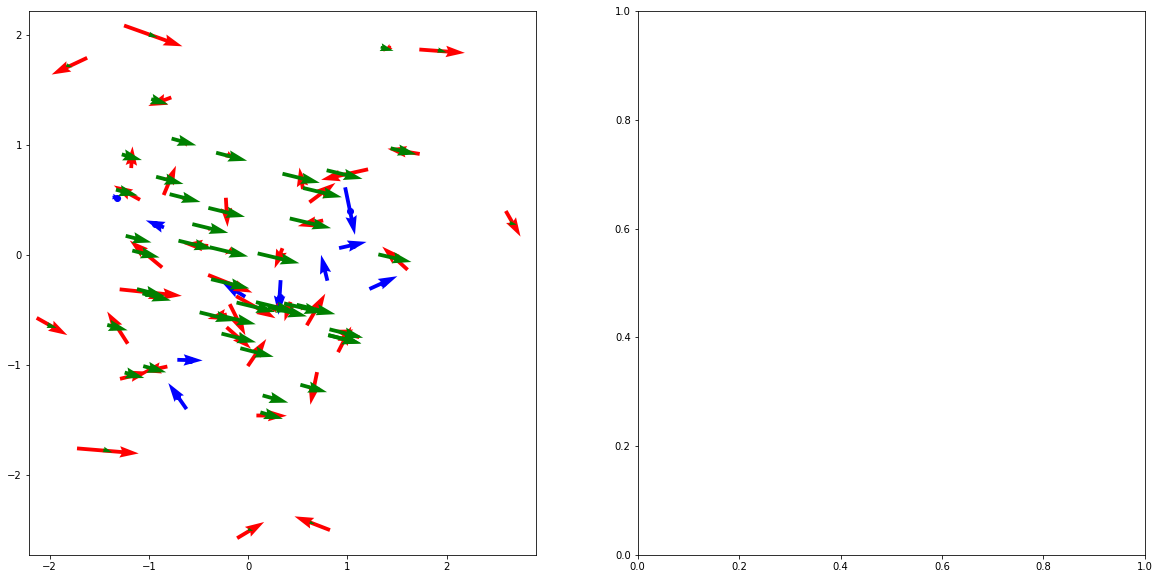

In [30]:
#Plot it to test:
Convolut_CNP.plot_Context_Target(X_Context,Y_Context,X_Target,Y_Target)